### Imports

In [1]:
import numpy as np
import pandas as pd

from preprocessor import Preprocessor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

### Preprocess
This Section is consisted of the following steps:
1. Load the data
2. Preprocess the data:
    1. drop columns - drop columns that are not needed
    2. extract date info - extract year, month, day, day of week, time and is_weekday
    3. extract season - extract season from month feature
    4. preprocess_discovery_time - preprocess the discovery time feature to extract hour and minute
    5. get county fips - get the country fips code from the latitude and longitude
    6. get demographic data - get the demographic data from the county fips code: population, gender, age, race
    7. add weather data - add weather data to the dataset: temperature, wind speed, precipitation
    8. transform date to cyclic - make cyclic transformation of the date features
3. Create a transformer for numeric features: impute missing values with the mean and scale the features
4. Create a transformer for categorical features: impute missing values with the most frequent value and one-hot encode the features
5. Combine transformers into a pipline

In [2]:
def create_pipeline(model):
    # Define the numeric and categorical features
    numeric_features, categorical_features = Preprocessor().define_features()
    # Creating a transformer for numeric features
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
    # Creating a transformer for categorical features
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # Combining transformers into a preprocessor
    columns_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
    
    return Pipeline(steps=[('columns_transformer', columns_transformer), ('model', model)])

In [3]:
# Load the data
train, test = pd.read_csv('./Data/train.csv'), pd.read_csv('./Data/test.csv')
train, test = Preprocessor().transform(train), Preprocessor().transform(test)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ste4dsv4-n01/code/Repos/Lab-DS/preprocessor.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['DISCOVERY_TIME'].fillna(0, inplace=True)
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ste4dsv4-n01/code/Repos/Lab-DS/preprocessor.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

### Model Train
This Section is consisted of the following steps:
1. Split the data into features and target
2. Create the model
3. fit the model


In [4]:
X_train, y_train = train.drop(columns=['STAT_CAUSE_DESCR']), train[['STAT_CAUSE_DESCR']]
X_test, y_test = test.drop(columns=['STAT_CAUSE_DESCR']), test[['STAT_CAUSE_DESCR']]

In [5]:
# Encode the target
train_category = pd.Categorical(y_train['STAT_CAUSE_DESCR'])
test_category = pd.Categorical(y_test['STAT_CAUSE_DESCR'])

y_train = train_category.codes
y_test = test_category.codes

In [6]:
model = XGBClassifier(booster='gbtree', objective='multi:softmax',eval_metric='auc', learning_rate=0.5, n_estimators=200, max_depth=10, random_state=42)
pipeline = create_pipeline(model)

In [7]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columns_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'DISCOVERY_TIMESTAMP',
                                                   'discovery_hour_sin',
                                                   'discovery_hour_cos',
                                                   'DISCOVERY_MONTH_sin',
                                                   'DISCOVERY_MONTH_cos',
                                                   'DISCOVERY_YEAR',
                                                   'DISCOVERY_DAY_sin',
                                                   'DISCOVERY_DAY_cos',
                                                   'DISCOVER...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

### Model Test

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from matplotlib import pyplot as plt

def plot_roc_curve(y_test, y_pred_proba, model_name, n_classes=12):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'yellow', 'black', 'brown', 'pink', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(test_category.categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

In [9]:
# show auc
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.8664590497816912

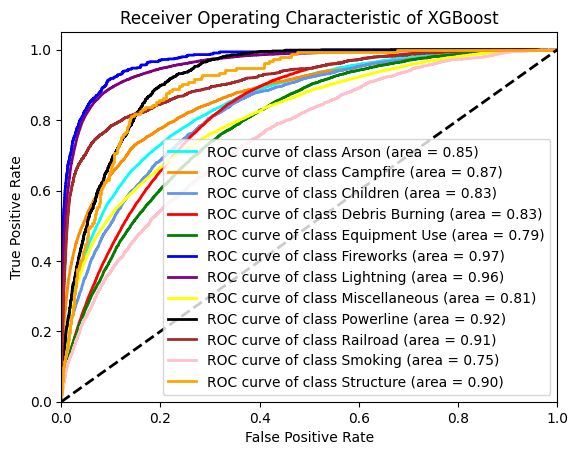

In [10]:
plot_roc_curve(y_test, y_pred_proba, 'XGBoost')

In [11]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.49      0.53     14663
           1       0.51      0.30      0.37      3410
           2       0.35      0.16      0.22      3189
           3       0.52      0.75      0.62     24685
           4       0.36      0.17      0.23      6665
           5       0.57      0.47      0.52       649
           6       0.73      0.82      0.77     13067
           7       0.53      0.51      0.52     15707
           8       0.22      0.07      0.10       827
           9       0.50      0.52      0.51      2067
          10       0.24      0.04      0.07      2784
          11       0.05      0.01      0.01       154

    accuracy                           0.55     87867
   macro avg       0.43      0.36      0.37     87867
weighted avg       0.53      0.55      0.53     87867



In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

def hyperparameter_tuning(model, param_dist, X_train, y_train, X_test, y_test, scoring='roc_auc_ovr_weighted', cv=5, n_iter=10, random_state=0):
    # Define the Randomized Search
    rs = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state, n_jobs=4, verbose=3)

    # Fit the Randomized Search
    rs.fit(X_train, y_train)

    # Print the best parameters
    print('Best parameters:', rs.best_params_)

    # Predict the classes and probabilities on the test data using the best model
    y_pred = rs.predict(X_test)
    y_pred_proba = rs.predict_proba(X_test)

    # Print the model performance
    print('Model Performance after Hyperparameter Tuning:')
    print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="weighted")}')
    print("Classification Report\n")
    print(classification_report(y_test, y_pred))
    plot_roc_curve(y_test, y_pred_proba, 'Model after Hyperparameter Tuning')
    
    return rs.best_estimator_, y_pred, y_pred_proba

In [13]:
# Define the hyperparameters for the best model
param_dist = {
    'model__objective': ['multi:softmax', 'multi:softprob'],
    'model__booster': ['gbtree', 'gblinear', 'dart'],
    'model__eval_metric': ['auc'],
    'model__learning_rate': np.linspace(0.1, 1, 10),
    'model__n_estimators': range(100, 200, 10),
    'model__max_depth': range(5, 15, 1),
    'model__alpha': np.linspace(0.5, 1.5, 10),
    'model__lambda': np.linspace(0, 0.5, 10),
}

best_model = hyperparameter_tuning(pipeline, param_dist, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END model__eval_metric=error, model__learning_rate=0.4, model__max_depth=11, model__n_estimators=160, model__objective=multi:softmax;, score=0.851 total time= 4.9min
[CV 5/5] END model__eval_metric=error, model__learning_rate=0.4, model__max_depth=11, model__n_estimators=160, model__objective=multi:softmax;, score=0.850 total time= 4.5min
[CV 5/5] END model__eval_metric=auc, model__learning_rate=0.9, model__max_depth=7, model__n_estimators=160, model__objective=binary:logistic;, score=0.843 total time= 2.6min
[CV 4/5] END model__eval_metric=error, model__learning_rate=0.7000000000000001, model__max_depth=8, model__n_estimators=120, model__objective=multi:softmax;, score=0.847 total time= 2.3min
[CV 3/5] END model__eval_metric=auc, model__learning_rate=0.5, model__max_depth=6, model__n_estimators=170, model__objective=binary:logistic;, score=0.848 total time= 2.4min
[CV 2/5] END model__eval_metric=auc, model__learning

/anaconda/envs/DSLAB/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [15]:
best_model[0].get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columns_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'DISCOVERY_TIMESTAMP',
                                                   'discovery_hour_sin',
                                                   'discovery_hour_cos',
                                                   'DISCOVERY_MONTH_sin',
                                                   'DISCOVERY_MONTH_cos',
                                                   'DISCOVERY_YEAR',
                         

In [19]:
model01 = best_model[0]

In [21]:
best_model[2]

array([[1.1104274e-01, 7.1980539e-03, 5.4066998e-01, ..., 6.4589217e-04,
        5.2065890e-02, 1.7388859e-04],
       [5.1262122e-02, 7.8795932e-02, 9.2188288e-03, ..., 1.8389032e-03,
        2.0531323e-02, 1.2589905e-04],
       [8.6843498e-02, 4.2287838e-03, 1.4247117e-02, ..., 5.8864936e-04,
        3.7076615e-02, 8.7333028e-05],
       ...,
       [7.4331015e-01, 1.8514756e-03, 1.1932058e-03, ..., 4.6039578e-03,
        6.7141391e-03, 2.7597068e-06],
       [4.5108968e-01, 2.9927712e-02, 1.0219017e-01, ..., 5.3799017e-03,
        7.4586272e-02, 1.5465822e-04],
       [1.2486238e-02, 3.8210291e-02, 2.2672934e-03, ..., 3.8896591e-04,
        5.8646859e-03, 5.6855379e-06]], dtype=float32)

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
